# Voice Activity Detection (VAD) using Silero VAD

This notebook demonstrates how to perform Voice Activity Detection (VAD) using the `silero-vad` library. We will:
1. Load and preprocess an audio file.
2. Apply the VAD algorithm to detect speech segments.
3. Visualize and output the detected speech segments.


## Step 1: Install and Import Dependencies

In [19]:
# Install required packages
!pip install -q torch torchvision numpy matplotlib soundfile silero-vad torchaudio

In [20]:
import torch
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
from pprint import pprint
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*cudnn.*')
warnings.filterwarnings('ignore', category=UserWarning, message='.*RNN module weights.*')

## Step 2: Load Libraries and Discover GPU Resources

In [21]:
# Check to see what GPU resources are available
def get_best_device():
    if torch.cuda.is_available():
        print("Using CUDA")
        return "cuda"
    elif torch.backends.mps.is_available():
        print("Using MPS")
        return "mps"
    else:
        print("Using CPU")
        return "cpu"
device = get_best_device()

Using CUDA


## Step 3: Load the Audio File

We start by loading an audio file using `soundfile`. The audio needs to be in a format supported by `silero-vad`.

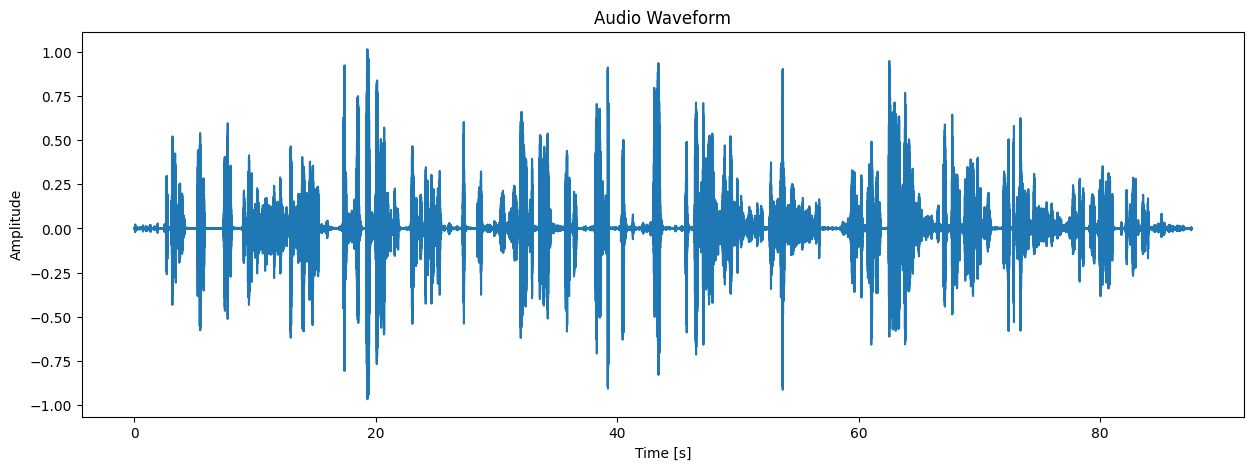

In [22]:
# Load the audio file
audio_filepath = "../test_pcm.wav"
audio, sample_rate = sf.read(audio_filepath)

# Ensure the audio is a 1D array
if audio.ndim > 1:
    audio = np.mean(audio, axis=1)

# Resample audio if necessary
if sample_rate != 16000:
    import resampy
    audio = resampy.resample(audio, sample_rate, 16000)
    sample_rate = 16000

# Convert audio to torch tensor
audio_tensor = torch.tensor(audio, dtype=torch.float32)

# Plot the audio waveform
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.title('Audio Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

## Step 4: Apply Silero VAD

Next, we initialize the `silero` VAD model and apply it to the audio file to detect speech segments.

In [23]:
# Initialize the Silero VAD model
vad_model, utils = torch.hub.load(
    repo_or_dir="snakers4/silero-vad", model="silero_vad", force_reload=True, onnx=False
)

(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils

# Apply the VAD model to the audio tensor
speech_timestamps = get_speech_timestamps(
    audio_tensor.numpy(), vad_model, sampling_rate=16000
)

# Extract speech segments
speech_segments = [
    (ts["start"] / sample_rate, ts["end"] / sample_rate) for ts in speech_timestamps
]

# Print the VAD segments
print("Detected speech segments (in seconds):")
for start, end in speech_segments:
    print(f"Start: {start:.2f}, End: {end:.2f}")

# Print VAD statistics: Number of speech segments, total duration of speech
# segments, and speech ratio
num_speech_segments = len(speech_segments)
total_duration = sum([end - start for start, end in speech_segments])
speech_ratio = total_duration / (len(audio) / sample_rate)
total_audio_length = len(audio) / sample_rate
print(f"\nNumber of speech segments: {num_speech_segments}")
print(f"Total length of audio: {total_audio_length:.2f} seconds")
print(f"Total duration of speech segments: {total_duration:.2f} seconds")
print(f"Speech ratio: {speech_ratio:.2f}")

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


Detected speech segments (in seconds):
Start: 3.04, End: 4.25
Start: 5.19, End: 5.95
Start: 7.39, End: 8.16
Start: 9.03, End: 15.39
Start: 17.25, End: 18.91
Start: 19.17, End: 21.98
Start: 22.88, End: 25.57
Start: 27.17, End: 27.52
Start: 28.42, End: 29.05
Start: 30.31, End: 33.18
Start: 33.51, End: 34.85
Start: 35.68, End: 36.73
Start: 38.15, End: 39.39
Start: 40.35, End: 40.83
Start: 42.98, End: 43.81
Start: 45.63, End: 45.95
Start: 46.40, End: 52.19
Start: 52.61, End: 56.93
Start: 59.30, End: 60.48
Start: 60.67, End: 61.95
Start: 62.47, End: 66.85
Start: 66.95, End: 67.42
Start: 67.68, End: 68.54
Start: 68.74, End: 71.01
Start: 71.97, End: 72.64
Start: 72.77, End: 76.89
Start: 77.06, End: 78.78
Start: 79.11, End: 81.21
Start: 82.11, End: 83.10
Start: 83.43, End: 84.13

Number of speech segments: 30
Total length of audio: 87.55 seconds
Total duration of speech segments: 56.23 seconds
Speech ratio: 0.64


## Step 5: Visualize the Detected Speech Segments

We visualize the detected speech segments on the audio waveform to better understand where speech occurs.

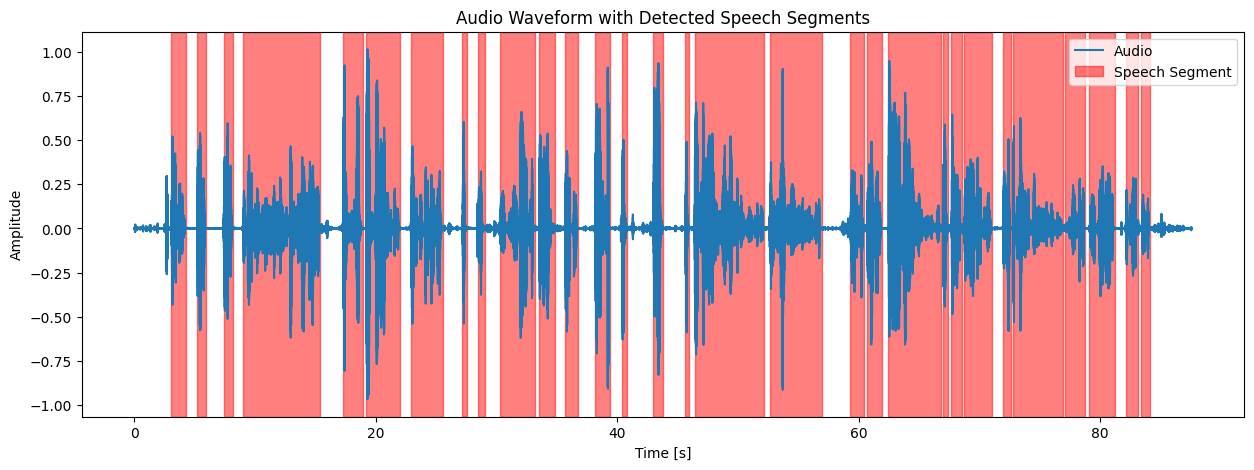

In [24]:
# Plot the audio waveform with detected speech segments
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio, label='Audio')
for start, end in speech_segments:
    plt.axvspan(start, end, color='red', alpha=0.5, label='Speech Segment' if start == speech_segments[0][0] else "")
plt.title('Audio Waveform with Detected Speech Segments')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Optional: Stream Imitation Example

This Stream Imitation Example demonstrates how to use the VADIterator class
from the Silero VAD library to process audio in a streaming manner. This
simulates real-time voice activity detection by processing small chunks of
audio sequentially, rather than processing the entire audio file at once. This
approach is particularly useful for applications where you need to perform VAD
on live audio streams, such as during a phone call or a video conference.

### Key Points
**State Maintenance**

The VADIterator class maintains the state of the VAD model across multiple
chunks, allowing for continuous detection without losing context.

**Real-Time Simulation**

By processing audio in small chunks sequentially, this method simulates how you
might perform VAD on a live audio stream.

**Chunk-Based Processing**

Each chunk is processed independently, but the state is preserved across
chunks, which is crucial for accurate detection in streaming scenarios.

**Example Output**

When the speech_dict is printed, it might show something like:

```python
[{'start': 0.0, 'end': 0.1}] [{'start': 0.1, 'end': 0.2}]
```

This indicates that speech was detected in the first chunk from 0.0 to 0.1
seconds, in the second chunk from 0.1 to 0.2 seconds, and so on.

### Practical Applications
**Live Streaming**

Useful in applications such as live transcription services, voice-controlled
systems, and real-time communication platforms where you need to detect voice
activity on-the-fly.

**Resource Efficiency**

Processing audio in chunks can be more memory and CPU efficient, as it avoids
loading and processing the entire audio file at once.

In [25]:
## using VADIterator class
# VADIterator is a helper class that maintains the state of the VAD model
# across multiple audio chunks. This is important for streaming applications
# where the model needs to remember the context between chunks.
vad_iterator = VADIterator(vad_model.to(device))

## Define the Window Size:
# This variable defines the number of audio samples in each chunk. A typical
# window size might be 1536 samples, which corresponds to approximately 96
# milliseconds of audio at a 16 kHz sampling rate (1536 / 16000).
window_size_samples = 1536

## Loop Over the Audio in Chunks
# Loop Initialization: The loop iterates over the audio file in steps of
# window_size_samples. In each iteration, it extracts a chunk of audio.
for i in range(0, len(audio), window_size_samples):
    # Chunk Extraction: 
    # chunk = audio[i: i + window_size_samples] extracts a chunk of audio
    # starting at index i and ending at i + window_size_samples.
    chunk = audio[i : i + window_size_samples]
    # Check for Incomplete Chunk: 
    # If the remaining audio is less than the window size, the loop breaks to
    # avoid processing incomplete chunks.
    if len(chunk) < window_size_samples:
        break
    # Process the Chunk: 
    # speech_dict = vad_iterator(chunk, return_seconds=True) processes the
    # chunk using the vad_iterator. The return_seconds=True parameter indicates
    # that the timestamps should be returned in seconds rather than sample
    # indices.
    chunk_tensor = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).to(device)
    speech_dict = vad_iterator(chunk_tensor, return_seconds=True)
    # Print Results: 
    # If the VAD model detects speech in the chunk, the results are printed.
    # The results include timestamps of detected speech segments within the
    # chunk.
    if speech_dict:
        print(speech_dict, end=' ')
# Reset States:
# After processing all chunks, vad_iterator.reset_states() resets the model's
# internal states. This is necessary to clear the context when processing a new
# audio stream or file.
vad_iterator.reset_states()

{'start': 2.6} {'end': 4.3} {'start': 5.3} {'end': 5.9} {'start': 7.5} {'end': 8.2} {'start': 9.1} {'end': 16.2} {'start': 17.2} {'end': 18.9} {'start': 19.2} {'end': 22.0} {'start': 22.8} {'end': 25.6} {'start': 26.0} {'end': 26.3} {'start': 27.1} {'end': 27.5} {'start': 28.5} {'end': 33.2} {'start': 33.6} {'end': 34.9} {'start': 35.7} {'end': 36.7} {'start': 38.1} {'end': 39.4} {'start': 40.4} {'end': 40.8} {'start': 43.0} {'end': 43.8} {'start': 45.6} {'end': 46.0} {'start': 46.3} {'end': 52.3} {'start': 52.6} {'end': 56.9} {'start': 58.6} {'end': 62.0} {'start': 62.5} {'end': 71.1} {'start': 72.0} {'end': 78.8} {'start': 79.1} {'end': 81.2} {'start': 82.1} {'end': 83.2} {'start': 83.4} {'end': 84.1} {'start': 84.5} {'end': 85.5} 

## Optional: Get Just Probabilities

In [26]:
# Get speech probabilities for each chunk
speech_probs = []
for i in range(0, len(audio), window_size_samples):
    chunk = audio[i: i + window_size_samples]
    if len(chunk) < window_size_samples:
        break
    chunk_tensor = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).to(device)
    speech_prob = vad_model(chunk_tensor, sample_rate).item()
    speech_probs.append(speech_prob)
vad_iterator.reset_states()  # reset model states after each audio

print(speech_probs[:10])  # first 10 chunks predicts

[0.0073374975472688675, 0.006694776471704245, 0.009508417919278145, 0.0007780868327245116, 0.001092117978259921, 0.008172104135155678, 0.00187684316188097, 0.0007466103415936232, 0.00020993877842556685, 0.00014281565381679684]


## Cleanup Models & Pipelines on GPU

In [27]:
# Cleanup models and pipelines from GPU memory
# If device is cuda then cleanup cuda resources, if mps, cleanup mps resources
if device == "cuda":
    torch.cuda.empty_cache()
elif device == "mps":
    torch.backends.mps.release_process_group()
    torch.backends.mps.destroy_process_group()
    torch.backends.mps.shutdown()
    torch.cuda.empty_cache()

## Conclusion

In this notebook, we demonstrated how to use the `silero-vad` library to detect speech segments in an audio file. We loaded and preprocessed the audio, applied the VAD algorithm, and visualized the detected speech segments. Optionally, we saved the detected speech segments as separate audio files for further analysis.